In [1]:
import pandas as pd

In [2]:
opsd = pd.read_csv("opsd_germany_daily.csv", parse_dates = ['Date'], index_col = 'Date')

In [3]:
opsd.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


The columns of the data are:

* Date — The date (yyyy-mm-dd format)
* Consumption — Electricity consumption in GWh
* Wind — Wind power production in GWh
* Solar — Solar power production in GWh
* Wind+Solar — Sum of wind and solar power production in GWh

### Visualizing time series data

Pandas `plot` method for Series/DataFrame object can be used to create a time series plot.

<AxesSubplot:xlabel='Date'>

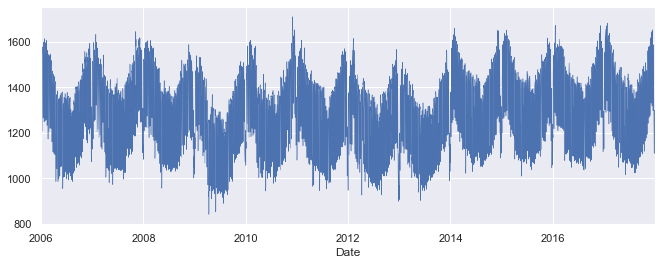

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (11, 4) # set the figure size
opsd.Consumption.plot(linewidth=0.5)

Note that the `plot` method has automatically chosen suitable locations (every two years) and labels (the years) for the x-axis, as well as grid lines.

Note, however, that due to so many points the plot is crowded and difficult to read. So lets zoom into the plot for years 2006 to 2008 only.

<AxesSubplot:xlabel='Date'>

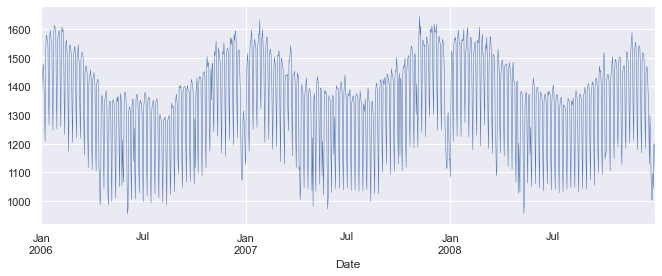

In [10]:
opsd.Consumption['2006':'2008'].plot(linewidth=0.5)

It can be ealily seen that the consumption is highest around the month of January and lowest around July.

Some more information is releled by further zooming into the Months.

<AxesSubplot:xlabel='Date'>

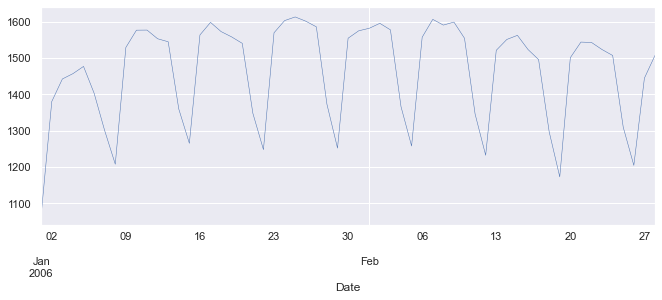

In [16]:
opsd.Consumption['Jan 2006': 'Feb 2006'].plot(linewidth=0.5)

Regular weekly fluctions are clearly visible in the time plot. To futher investidate this, Lets have a still closer look.

<AxesSubplot:xlabel='Date'>

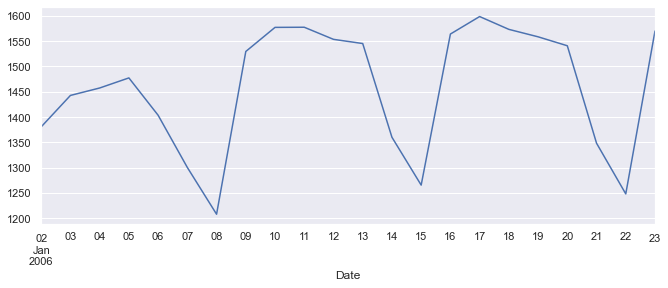

In [34]:
opsd.Consumption['01/02/2006': '01/23/2006'].plot()

Note that the consumption is lowest on 8th, 15th, and 22nd January. These dates are exactly one week apart.

To see, which weekday it is, lets investigate as shown below.

In [32]:
lday = pd.DatetimeIndex(['01/08/2006'], tz = 'Brazil/Acre')
lday.strftime("%A")

Index(['Sunday'], dtype='object')

So, we notice that during the weekends the consumption decreases to minimum and it increases during week days.

### Removing seasonal component

As we have noted above there are two seasonal components in the opsd time series data. One with a frequency of Week and another with a frequency of Year.

We can remove the seasonal component with Week as its frequency, by computing weekly means. This can be achieved by *down sampling* the time series from daily to weekly.

However, before we do that we need to do some preprocessing of data. First lets check the "frequency" of DatetimeIndex of our time series. 

In [37]:
opsd.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

Note that the frequency is None. This is because we have read the data from csv file, which readily contained the dates.

So, lets first set the frequency of our time series. Since we know that we have a time series with daily records, we shall set the the frequency as daily.

In [38]:
opsd = opsd.asfreq('D')

Above operation may have introduced some missing dates for which the data was not available. The corresponding time series values would be missing in the data.

Next, we check whether there are any missing observations in our time series.

In [50]:
opsd.Consumption.isnull().any()

False

This it is confirmed that there is no missing date in our data. 

Next we go ahead with down sampling using the `resample` method and use `mean` as an aggregation function. 

In [57]:
opsdWeekly = opsd.resample('W').mean()

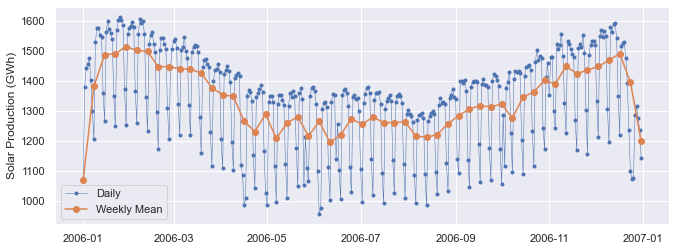

In [53]:
fig, ax = plt.subplots()
ax.plot(opsd.Consumption['Jan 2006':'Dec 2006'],
        marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(opsdWeekly.Consumption['Jan 2006':'Dec 2006'],
        marker='o', markersize=6, linestyle='-', label='Weekly Mean')
ax.set_ylabel('Solar Production (GWh)')
ax.legend();

Note that the time series of weekly means of consumption is smoother than the the time series of daily data. However, the frequencies of the two time series are different.

### Deseasonalizing time Series

To deseasonalize a time series without changing the frequency, we can use *rolling windows* (Moving Windows) functions of Pandas as shown below.

In [70]:
opsd_Weekly_removed = opsd.rolling(7, center = True).mean()

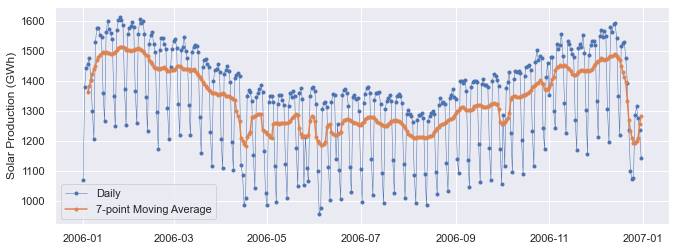

In [72]:
fig, ax = plt.subplots()
ax.plot(opsd.Consumption['Jan 2006':'Dec 2006'],
        marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(opsd_Weekly_removed.Consumption['Jan 2006':'Dec 2006'],
        marker='.', linestyle='-', label='7-point Moving Average')
ax.set_ylabel('Solar Production (GWh)')
ax.legend();

Now, the second seasonal compnent can also be removed by using 365-point moving average.

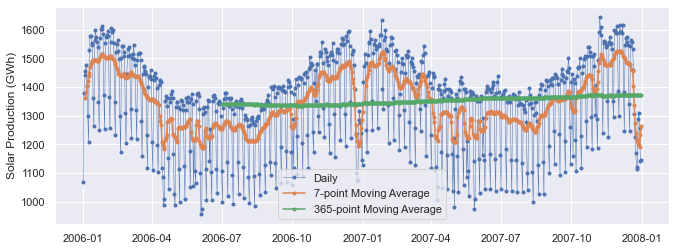

In [101]:
opsd_Yearly_removed = opsd.rolling(365, center = True).mean()
fig, ax = plt.subplots()
ax.plot(opsd.Consumption['Jan 2006':'Dec 2007'],
        marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(opsd_Weekly_removed.Consumption['Jan 2006':'Dec 2007'],
        marker='.', linestyle='-', label='7-point Moving Average')
ax.plot(opsd_Yearly_removed.Consumption['Jan 2006':'Dec 2007'],
        marker='.', linestyle='-', label='365-point Moving Average')
ax.set_ylabel('Solar Production (GWh)')
ax.legend();

The deseasonalized series, after removing the seasonal component with annual frequency, clearly reveals the *trend* of increasing consumption over time.

The Yearly Moving average time series looks almost like a straight line. However, we can zoom into it to see if there are still any fluctuations.

<AxesSubplot:xlabel='Date'>

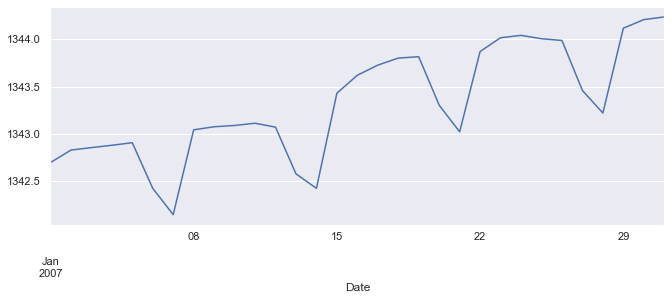

In [114]:
opsd_Yearly_removed.Consumption['Jan 2007'].plot()

So it can be seen that the weekly fluctions are still present in the data. 

To remove both the seasonal components, we need to apply both the deseasonalization operations on the same series, one after another.

In [105]:
opsd_deseasonalized = opsd.rolling(7, center = True).mean().rolling(365, center = True).mean()

<AxesSubplot:xlabel='Date'>

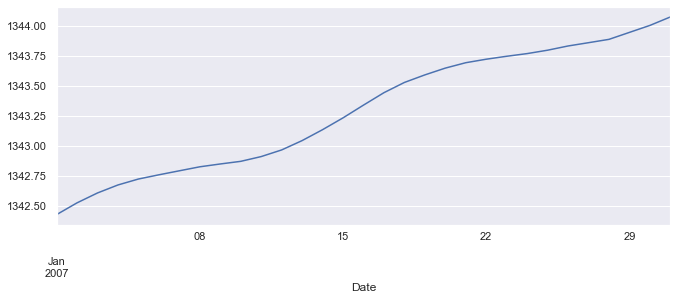

In [124]:
opsd_deseasonalized.Consumption['Jan 2007'].plot()

<AxesSubplot:xlabel='Date'>

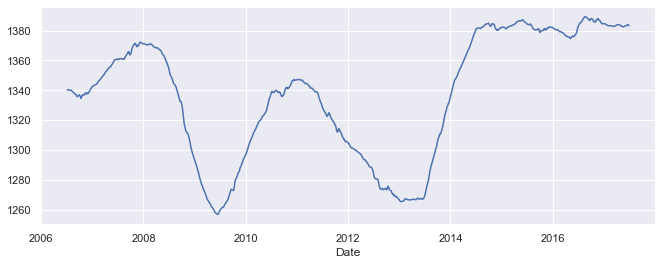

In [133]:
opsd_deseasonalized.Consumption.plot()

The plot indicates possible presence of cycles. However, to clearly identify if there are any cycles, we need to have data for more years.